In [2]:
from torch.utils.data import DataLoader, Dataset
from mpi4py import MPI
import blobfile as bf
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, resolution, image_paths, classes=None, shard=0, num_shards=1):
        super().__init__()
        self.resolution = resolution
        self.local_images = image_paths[shard:][::num_shards]
        self.local_classes = None if classes is None else classes[shard:][::num_shards]

    def __len__(self):
        return len(self.local_images)

    def __getitem__(self, idx):
        path = self.local_images[idx]
        arr = torch.load(path)


        # We are not on a new enough PIL to support the `reducing_gap`
        # argument, which uses BOX downsampling at powers of two first.
        # Thus, we do it by hand to improve downsample quality.
        while min(*pil_image.size) >= 2 * self.resolution:
            pil_image = pil_image.resize(
                tuple(x // 2 for x in pil_image.size), resample=Image.BOX
            )

        scale = self.resolution / min(*pil_image.size)
        pil_image = pil_image.resize(
            tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
        )

        arr = arr.numpy()
        crop_y = (arr.shape[0] - self.resolution) // 2
        crop_x = (arr.shape[1] - self.resolution) // 2
        arr = arr[crop_y : crop_y + self.resolution, crop_x : crop_x + self.resolution]
        arr = arr.astype(np.float32) / 127.5 - 1

        out_dict = {}
        if self.local_classes is not None:
            out_dict["y"] = np.array(self.local_classes[idx], dtype=np.int64)
        return arr, out_dict


In [35]:
    dataset = ImageDataset(
        32,
        '/home/ismail/diffusion_lung_2d/datasets/cifar_32_32/bird_00006.png',
        classes=None,
        shard=MPI.COMM_WORLD.Get_rank(),
        num_shards=MPI.COMM_WORLD.Get_size(),
    )

In [103]:
with bf.BlobFile('/home/ismail/diffusion_lung_2d/datasets/cifar_32_32/bird_00006.png', "rb") as f:
    pil_image = Image.open(f)
    pil_image.load()

In [104]:
arr = np.array(pil_image.convert("RGB"))


In [105]:
arr.shape

(32, 32, 3)

In [33]:
target = torch.load('datasets/lung_8_128/target.pt')
target = target.reshape(target.shape[0], target.shape[1], 1)
target = (target * 255).to(torch.uint8)
rgb_target = torch.concatenate((target, target, target), axis=2)
torch.save(rgb_target,'rgb_target.pt')

In [26]:
target.shape

torch.Size([8, 256, 1])

In [31]:
rgb_target.shape

torch.Size([8, 256, 3])

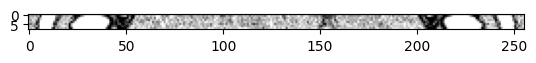

In [30]:
plt.imshow(rgb_target)

In [39]:
rgb_target.numpy().shape

(8, 256, 3)

In [7]:
with bf.BlobFile('/home/ismail/diffusion_lung_2d_1chanel/datasets/lung_8_256/2.png', "rb") as f:
    pil_image = Image.open(f)
    pil_image.load()


In [5]:
 arr = np.array(pil_image.convert("RGB"))

In [82]:
target = torch.load('/home/peter/data/2dmap/716.pt')[:32, :]
target = target.reshape(target.shape[0], target.shape[1], 1)
rgb_tensor = torch.cat((target, target, target), dim=2)
rgb_tensor = torch.transpose(rgb_tensor,0,2).transpose(1,2)
to_pil = transforms.ToPILImage()
rgb_image = to_pil(rgb_tensor)
rgb_image.save('rgb_image.png')


In [3]:
model = torch.load('/home/ismail/diffusion_lung_2d/models/lung_ema_0.9999_040000.pt')

In [5]:
for i in model:
    print(i)

time_embed.0.weight
time_embed.0.bias
time_embed.2.weight
time_embed.2.bias
input_blocks.0.0.weight
input_blocks.0.0.bias
input_blocks.1.0.in_layers.0.weight
input_blocks.1.0.in_layers.0.bias
input_blocks.1.0.in_layers.2.weight
input_blocks.1.0.in_layers.2.bias
input_blocks.1.0.emb_layers.1.weight
input_blocks.1.0.emb_layers.1.bias
input_blocks.1.0.out_layers.0.weight
input_blocks.1.0.out_layers.0.bias
input_blocks.1.0.out_layers.3.weight
input_blocks.1.0.out_layers.3.bias
input_blocks.2.0.op.weight
input_blocks.2.0.op.bias
input_blocks.3.0.in_layers.0.weight
input_blocks.3.0.in_layers.0.bias
input_blocks.3.0.in_layers.2.weight
input_blocks.3.0.in_layers.2.bias
input_blocks.3.0.emb_layers.1.weight
input_blocks.3.0.emb_layers.1.bias
input_blocks.3.0.out_layers.0.weight
input_blocks.3.0.out_layers.0.bias
input_blocks.3.0.out_layers.3.weight
input_blocks.3.0.out_layers.3.bias
input_blocks.4.0.op.weight
input_blocks.4.0.op.bias
input_blocks.5.0.in_layers.0.weight
input_blocks.5.0.in_layers

In [1]:
# Load the .npz file
data = np.load('/home/ismail/diffusion_lung_2d/results/samples_16x256x256x3.npz')
images = data['arr_0']
for image in images:
    plt.imshow(image)
    plt.show()

NameError: name 'np' is not defined

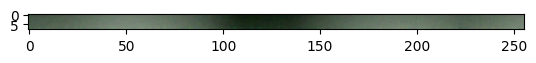

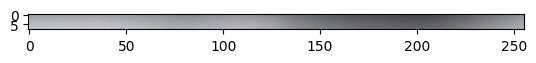

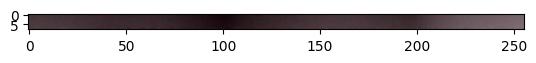

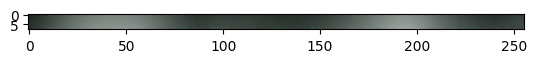

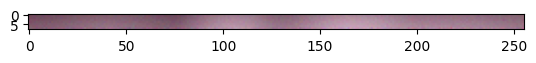

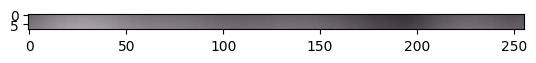

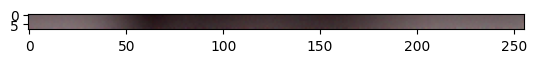

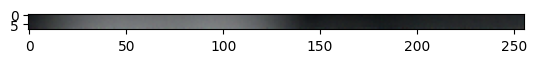

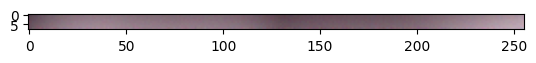

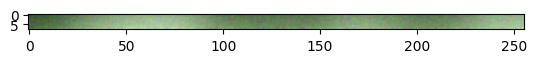

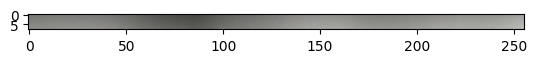

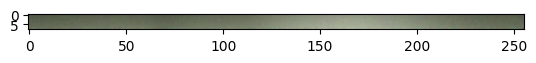

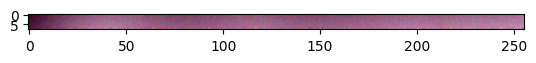

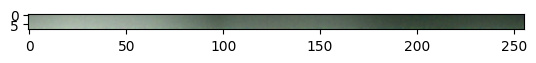

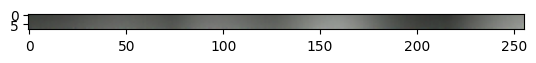

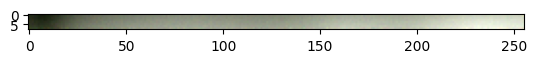

In [4]:
# Load the .npz file
data = np.load('/home/ismail/diffusion_lung_2d_1chanel/results/samples_16x8x256x3.npz')
images = data['arr_0']
for image in images:
    plt.imshow(image)
    plt.show()

In [6]:
rgb_image = images[0]

In [7]:
gray_image = np.dot(rgb_image[...,:3], [0, 0, 1])


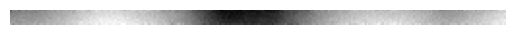

In [8]:
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()